### Analyzing Spike Recordings
#### Methods from Tong-Wey
- The amplifier's high pass filter is set at 10 Hz and low pass filter at 3 kHz.
- Nerve cell recordings from  were acquired at 10kHz. 
- The raw spikes were recorded in a .abf format on Clampex 10.4 by Molecular Devices. The files have be converted into a .atf format, which can be opened with Microsoft Excel. 

#### To-do
- Open the `.atf` file of interest.
- From `expt_details.xlsx`, read off the protocol used, illumination strength, larval identity, and abdominal segment.
- Attach these experimental details to the `.atf` file.
- Bandpass filter each trace.
- Plot the frequency spectrum and spectrogram before and after filtering, and save the image.
- Extract before, during and after epochs.
- Count the spikes for each of these epochs.
- Calculate the spike frequency.
- Plot by sweep, per larva.

#### Initialize variables

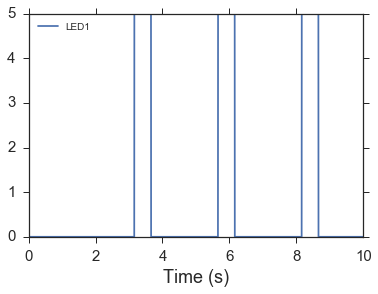

In [8]:
led1pro = pd.read_excel('/Users/josesho/Google Drive/ACC Lab/ACR/2016-09-25&26 Larval nerve/LED1 protocol.xlsx',
                       index_col = 'Time (s)')
led1pro.plot()

In [1]:
!date
# Set the directory with all the .atf files.
# The code in `Main Loop` will loop through all the directories and read in files with .atf extension.
datadir = '/Users/josesho/Google Drive/ACC Lab/ACR/2016-09-25&26 Larval nerve/ATF_files/'

# Sample rate. MUST BE SAME ACROSS ALL NERVE RECORDINGS.
fs = 10000.0       

# Here we implement Tracey et al. 2003 bandpass settings.
lowcut = 100.0     # discard frequencies lower than this.
highcut = 1500.0   # discard frequencies higher than this.
order = 5         # order of the Butterworth filter (not exactly sure what this means, 
                   # but the higher the order, the "tighter" the cutoff.
    
# Define the datetimes and timedeltas here.
import datetime 
starttime = datetime.datetime(2016, 7, 1, 0, 0, 3, 156100) # Assigns arbitrary date for easy parsing.
#### READ THIS FROM TONG-WEY'S SPREADSHEET ####
# 0.1561 seconds = 156100 microseconds.
pulse = datetime.timedelta(milliseconds = 500)
pulseInterval = datetime.timedelta(seconds = 2)

Thu Sep 29 18:09:25 SGT 2016


#### Load Libraries and Custom Commands

In [2]:
import seaborn as sb
import pandas as pd
import numpy as np
import os
from numpy import fft
from scipy import signal
import matplotlib.pyplot as plt
import bootstrapContrast as bs
%matplotlib inline
sb.set_style('ticks')
plt.rcParams['svg.fonttype'] = 'none' # Ensures the text in figures are not lines but text.

def convert_time(a):
    sec = int(a) # get the second
    temp_us = round(a, 6) # round to 6 decimal places.
    us = str(a).split(".")[-1]
    mult = 6 - len(us)
    # extract the numbers after the decimal place. 
    # we need to add enough zeros so that we get
    # microseconds (1 millionth of a second).
    return datetime.datetime(2016, 7, 1, 0, 0, sec, int(us)*(10**mult))

# Bandpass filter.
# Taken from http://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    from scipy.signal import butter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    from scipy.signal import lfilter
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plotSpectrum(y, Fs, ax):
    """ Plots a Single-Sided Amplitude Spectrum of y(t)
    Modified from: http://glowingpython.blogspot.sg/2011/08/how-to-plot-frequency-spectrum-with.html """
    import numpy as np
    from numpy import fft
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[ np.arange( int(n/2) ) ] # one side frequency range

    Y = fft.fft(y)/n # fft computing and normalization
    Y = Y[ np.arange( int(n/2) ) ]

    ax.plot(frq, abs(Y),'r') # plotting the spectrum
    ax.set_xlabel('Freq (Hz)', fontsize = 12)
    ax.set_ylabel('|Y(freq)|', fontsize = 12)

def plotSpectrogram(y, Fs, ax, colmap = 'plasma', ylim = (0,2000)):
    """ Plots a Spectrogram of `y`, given the sampling frequency `fs`.
    Modified from: http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html """
    from scipy import signal
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)            # For more colormaps, see 
                                           # http://matplotlib.org/examples/color/colormaps_reference.html
    # (y,x,z) of spectrogram
    f, t, Sxx = signal.spectrogram(y, Fs)
    ax.pcolormesh(t, f, Sxx, cmap = cmap, axes = ax)
    ax.set_ylim(ylim)
    ax.set_ylabel('Frequency [Hz]', fontsize = 12)
    ax.set_xlabel('Time [sec]', fontsize = 12)
    
    
def to_seconds(t, pos):
    sec = str(t/10000)
    return sec

# I need to give the timeseries itself AND the lighton protocol.
def bandpassFilter(series, 
                   # lighton, 
                   fname = 'bandpassFilter', 
                   fileformat = 'png', 
                   dpi = 500, 
                   titlefs = 15,
                   fs = 10000,
                   lowcut = 100,
                   highcut = 2000,
                   order = 5,   
                   plotsize = (18, 12)):
    '''Takes a pandas Series and bandpass filters it with a Butterworth filter.
    It will produce two things: 
    a before-and-after plot with a frequency spectrum and a spectrogram, and a
    pandas Series of the bandpass filtered data.
    '''
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    secFmt = FuncFormatter(to_seconds)
    
    # Parse the lighton series. Get the indexes where LED > 0.
    # Use these indexes later to 'color in' the illumination epochs.
    
    # Create figure. 
    fig, axarr = plt.subplots(nrows = 3, ncols = 2, figsize = plotsize)

    # Plot the raw trace.
    series.plot( ax = axarr[0,0], figsize = plotsize )
    axarr[0,0].set_title( fname + " Raw Trace", fontsize = titlefs )
    axarr[0,0].yaxis.set_major_formatter(secFmt) # Make sure the x-axis is in seconds.
    axarr[0,0].set_ylabel('mV', fontsize = 12)
    axarr[0,0].set_ylabel('Time [sec]', fontsize = 12)

#         # Color in light on epochs on the raw trace. 
#         for epoch in lightEpochs:
#             axarr[0].axvspan(xmin = epoch[0], 
#                              xmax = epoch[-1], 
#                              ymin = -1, ymax = 1, 
#                              alpha = 0.25, color = 'grey')

    # Plot spectrogram of raw trace.
    plotSpectrogram( y = series, Fs = fs, ax = axarr[1,0])
    axarr[1,0].set_title( fname + " Raw Spectrogram", fontsize = titlefs )

    # Plot frequency spectrum of raw trace.
    plotSpectrum( y = series, Fs = fs, ax = axarr[2,0] )
    axarr[2,0].set_title( fname + " Raw Frequency Spectrum", fontsize = titlefs )

    # Bandpass filter raw trace according to Tracey et al. 2003 settings: 100Hz – 2kHz.
    bandpass = pd.Series( butter_bandpass_filter(series, lowcut, highcut, fs, order) )
    bandpass.index = series.index # Set index of bandpass trace.

    # Plot the bandpass trace.
    bandpass.plot( ax = axarr[0,1], figsize = plotsize )
    axarr[0,1].set_title( fname + " Bandpass Trace", fontsize = titlefs )
    axarr[0,1].yaxis.set_major_formatter(secFmt)
    axarr[0,1].set_ylabel('mV')
    
#         # Color in light on epochs on the bandpass trace. 
#         for epoch in lightEpochs:
#             axarr[3].axvspan(xmin = epoch[0], 
#                              xmax = epoch[-1], 
#                              ymin = -1, ymax = 1, 
#                              alpha = 0.25, color = 'grey')

    # Plot spectrogram of bandpass trace.
    plotSpectrogram( y = bandpass, Fs = fs, ax = axarr[1,1])
    axarr[1,1].set_title( fname + " Bandpass Spectrogram", fontsize = titlefs )

    # Plot frequency spectrum of bandpass trace.
    plotSpectrum( y = bandpass, Fs = fs, ax = axarr[2,1] )
    axarr[2,1].set_title( fname + " Bandpass Frequency Spectrum", fontsize = titlefs )

    # Aesthetic tweaks
    for arr in axarr:
        for a in arr:
            sb.despine(ax = a)
    fig.tight_layout()
    fig.savefig(fname + '.' + fileformat, 
                format = fileformat, dpi = dpi)

    return fig, bandpass

#### Main Loop

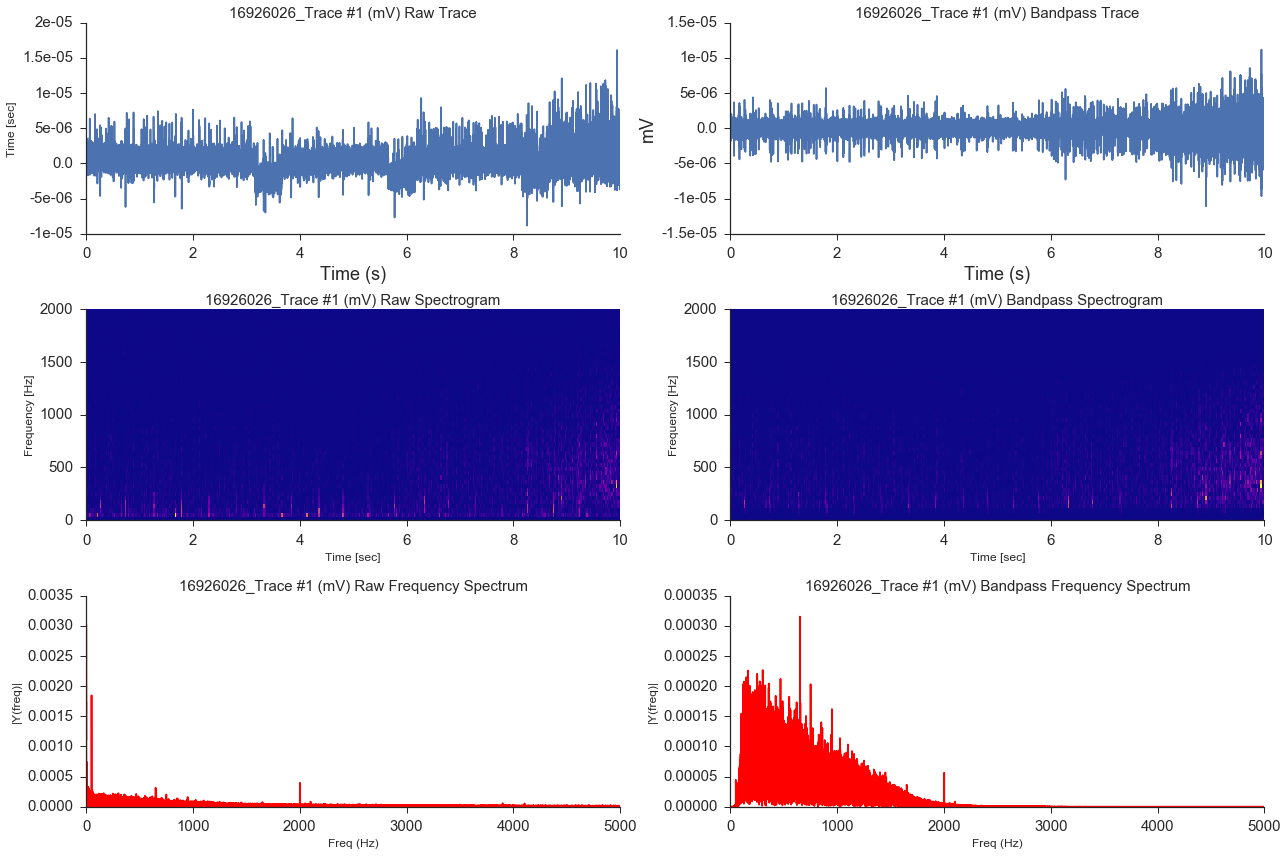

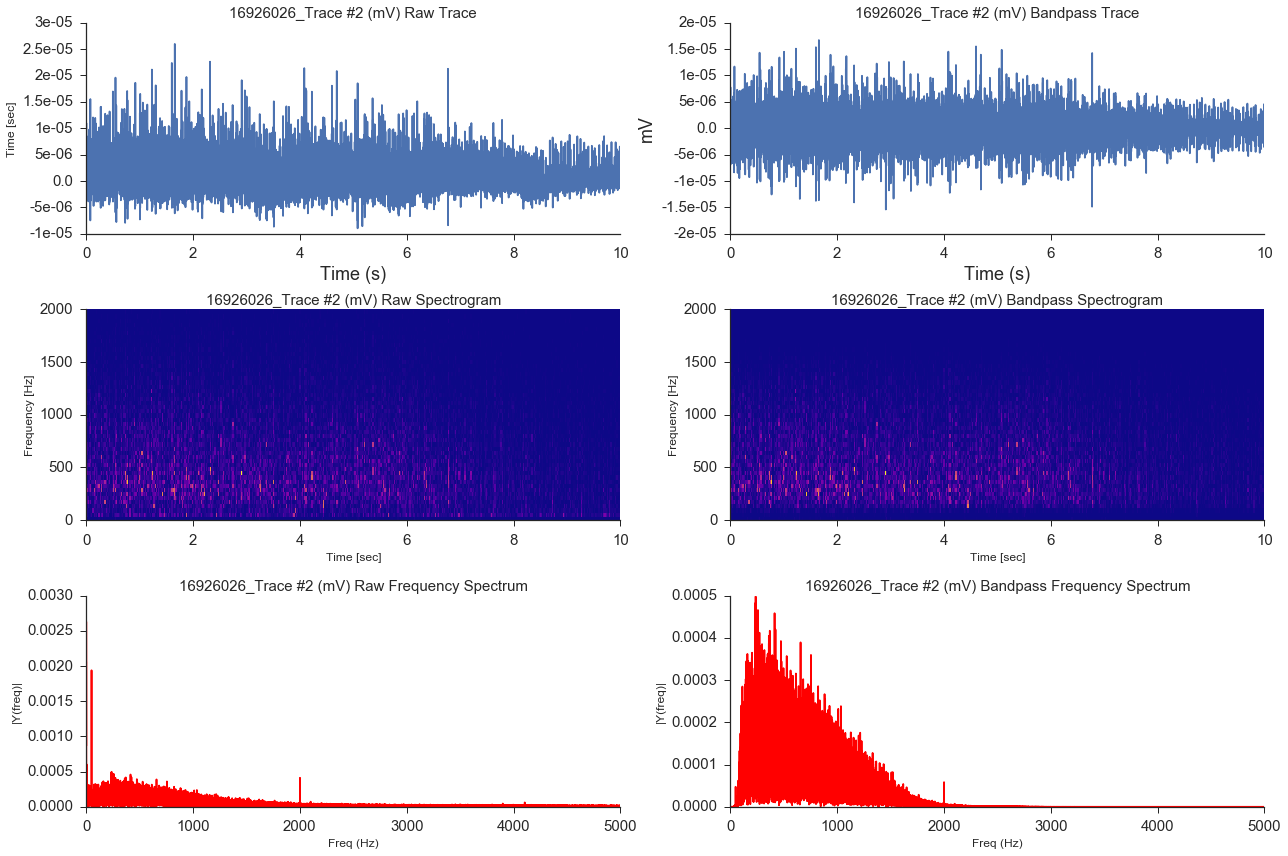

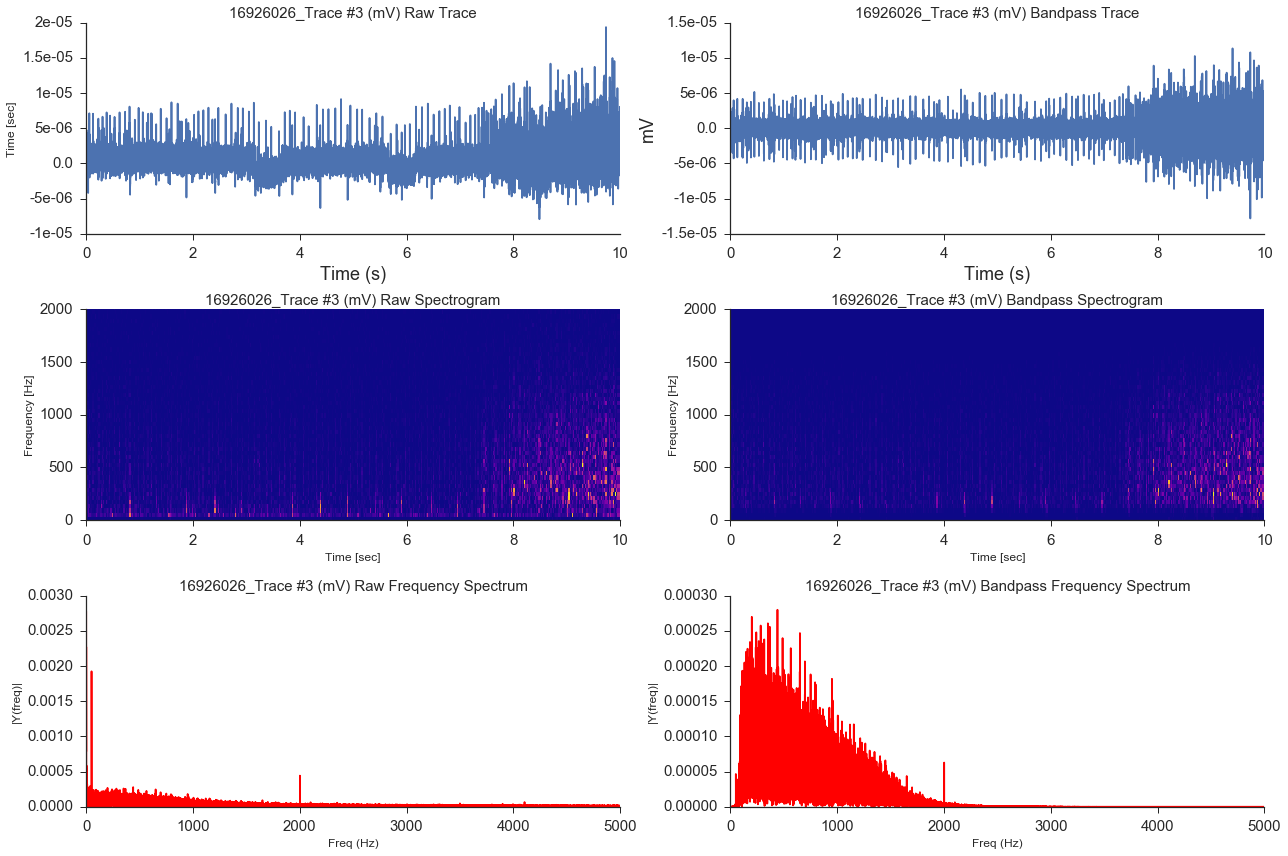

In [4]:
fname = datadir + '500ms_LED/16926026.atf'
df = pd.read_csv(fname,
                 sep='\t',
                 skiprows = range(0,10),    # Skips the first 10 rows.
                 index_col = 'Time (s)'
                  ) 

dfname = '16926026'
# Get relevant LED illumination protocol.

for i, c in enumerate(df.columns):
    # Parse trace title.
    fname = dfname + '_' + df.columns[i]
    # obtain bandpass filtered trace, plot basic summary plots.
    _, test_bp = bandpassFilter(df[c], # timeseries
                                # lightOn,  # lightOn protocol goes here
                                fname = fname,       
                                fs = fs,
                                lowcut = lowcut,
                                highcut = highcut,
                                order = order)
    
    # Extract pulse length from lightOn
    # Extract before, during and after pulses from bp-filtered timeseries.

In [ ]:
os.chdir(datadir) # change to datadir.

for subdir, dirs, files in os.walk(datadir): # loop thru the subdirectories in datadir. 
    for file in files:
        if (len(file.split('.')) > 1) and (file.split('.')[1] == 'atf'):
            # if and only if the file extension is `.atf`...
            fname = os.path.join(subdir, file)
            test = pd.read_csv(fname, sep='\t', skiprows = range(0,10)) # Skips the first 10 rows.
            fname = "" + file.split('.')[0] + "_frequencySpectra_Spectrogram"
            plotSummaryGraphs(test)